# QCoDeS Example with Stanford SR830

In this notebook, we are presenting how to connect to SR830 lock-in amplifier and read its buffer in QCoDeS. The instrument is not connected to any other instrument while running this notebook, so the buffer is only showing the instrument noise data.

### Imports and connecting to the instrument

In [1]:
from time import sleep

import numpy as np

from qcodes.dataset import do0d, load_or_create_experiment
from qcodes.instrument import Instrument
from qcodes.instrument_drivers.stanford_research import SR830
from qcodes.validators import Numbers

In [2]:
sr = SR830('lockin', 'GPIB0::7::INSTR')
load_or_create_experiment(experiment_name='SR830_notebook')

Connected to: Stanford_Research_Systems SR830 (serial:s/n54436, firmware:ver1.07) in 0.26s
Upgrading database; v0 -> v1: : 0it [00:00, ?it/s]
Upgrading database; v1 -> v2: 100%|█████████████████████████████████████████████████████| 1/1 [00:00<00:00, 507.48it/s]
Upgrading database; v2 -> v3: : 0it [00:00, ?it/s]
Upgrading database; v3 -> v4: : 0it [00:00, ?it/s]
Upgrading database; v4 -> v5: 100%|█████████████████████████████████████████████████████| 1/1 [00:00<00:00, 334.85it/s]
Upgrading database; v5 -> v6: : 0it [00:00, ?it/s]
Upgrading database; v8 -> v9: 100%|█████████████████████████████████████████████████████| 1/1 [00:00<00:00, 334.74it/s]


SR830_notebook#some_sample#1@C:\Users\qt9usr\experiments.db
-----------------------------------------------------------

Let's quickly look at the status of the instrument after connecting to it:

In [3]:
sr.print_readable_snapshot()

lockin:
	parameter       value
--------------------------------------------------------------------------------
IDN              :	{'vendor': 'Stanford_Research_Systems', 'model': 'SR830', ...
P                :	None (deg)
R                :	None (V)
R_offset         :	None 
X                :	None (V)
X_offset         :	None 
Y                :	None (V)
Y_offset         :	None 
amplitude        :	None (V)
aux_in1          :	None (V)
aux_in2          :	None (V)
aux_in3          :	None (V)
aux_in4          :	None (V)
aux_out1         :	None (V)
aux_out2         :	None (V)
aux_out3         :	None (V)
aux_out4         :	None (V)
buffer_SR        :	1 (Hz)
buffer_acq_mode  :	None 
buffer_npts      :	None 
buffer_trig_mode :	None 
ch1_databuffer   :	Not available (V)
ch1_datatrace    :	Not available (V)
ch1_display      :	X 
ch1_ratio        :	none 
ch2_databuffer   :	Not available (V)
ch2_datatrace    :	Not available (V)
ch2_display      :	Y 
ch2_ratio        :	none 
complex_voltage  :	None

### Basics of reading values from the lockin

A parameter say `complex_voltage` can be read from the lockin as follows.

In [5]:
sr.complex_voltage()

(-7.15259e-07+1.43052e-06j)

In fact, a method name `snap` is available on SR830 lockin which allows the user to read 2 to 6 parameters simultaneously out of the following.

In [6]:
from pprint import pprint

pprint(list(sr.SNAP_PARAMETERS.keys()))

['x',
 'y',
 'r',
 'p',
 'phase',
 'θ',
 'aux1',
 'aux2',
 'aux3',
 'aux4',
 'freq',
 'ch1',
 'ch2']


Method `snap` can be used in the following manner. 

In [7]:
sr.snap('x','y','phase')

(-3.33787e-06, 4.05314e-06, 128.658)

### Changing the Sensitivity
The driver can change the sensitivity automatically according to the R value of the lock-in.
So instead of manually changing the sensitivity on the front panel, you can simply run this in your data acquisition or Measurement (max_changes is an integer defining how many steps the autorange can change the sensitivity, the default is 1 step):

In [4]:
sr.autorange(max_changes=2)

### Preparing for reading the buffer and measurement

The SR830 has two internal data buffers corresponding to the displays of channel 1 and channel 2.
Here we present a simple way to use the buffers.
The buffer can be filled either at a constant sampling rate or by sending an trigger. 
Each buffer can hold 16383 points. The buffers are filled simultaneously. The QCoDeS driver always pulls the entire buffer, so make sure to reset (clear) the buffer of old data before starting and acquisition.

We setup channel 1 and the buffer to be filled at a constant sampling rate:

In [5]:
sr.ch1_display('X')
sr.ch1_ratio('none')
sr.buffer_SR(512)  # Sample rate (Hz)
sr.buffer_trig_mode.set('OFF')

We fill the buffer for one second as shown below:

In [6]:
sr.buffer_reset()
sr.buffer_start() # Start filling the buffers with 512 pts/s
sleep(1)
sr.buffer_pause()  # Stop filling buffers

Now we run a QCoDeS Measurement using do0d to get the buffer and plot it:

Starting experimental run with id: 50. 


(results #50@C:\Users\Farzad\experiments.db
 ------------------------------------------
 lockin_sweep_setpoints - array
 lockin_ch1_datatrace - array,
 [<AxesSubplot:title={'center':'Run #50, Experiment SR830_notebook (some_sample)'}, xlabel='Time (ms)', ylabel='X (nV)'>],
 [None])

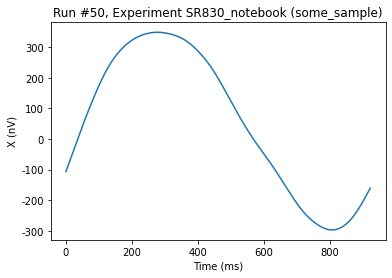

In [7]:
do0d(sr.ch1_datatrace, do_plot=True)

### Software trigger
Below we will illustrate how a software trigger can be sent to fill the buffer on the instrument. For Illustrative purposes, we define a Dummy Generator, that we wish to set before each measurement. 

In [8]:
class DummyGenerator(Instrument):

    def __init__(self, name, **kwargs):

        super().__init__(name, **kwargs)

        self.add_parameter('v_start',
                           initial_value=0,
                           unit='V',
                           label='v start',
                           vals=Numbers(0,1e3),
                           get_cmd=None,
                           set_cmd=None)

        self.add_parameter('v_stop',
                           initial_value=1,
                           unit='V',
                           label='v stop',
                           vals=Numbers(1,1e3),
                           get_cmd=None,
                           set_cmd=None)

        self.add_parameter('v_gen',
                           initial_value=0,
                           unit='V',
                           label='v_gen',
                           vals=Numbers(self.v_start(),self.v_stop()),
                           get_cmd=None,
                           set_cmd=None)

In [9]:
gen = DummyGenerator('gen')

We can now setup the lock-in to use the trigger 

In [10]:
sr.ch1_ratio('none')
sr.buffer_SR("Trigger")
sr.buffer_trig_mode.set('ON')

We need to connect the data strored in the buffer to the correspointing values of the Dummy Generator,
i.e we need to give the setpoints for the data to be stored in the buffer.
For this purperse the driver has the convience function set_sweep_parameters, that generates the setpoint with units and labels corresponding to the independent parameter her (gen.v_gen).

In [11]:
sr.set_sweep_parameters(gen.v_gen,0,1,100)

To fill the buffer we iterate through values of the sweep_setpoints and change the value of the Dummy Generator followed by a software trigger. To get and plot the data we use the do0d.

In [12]:
sr.buffer_reset()
for v in sr.sweep_setpoints.get():
    gen.v_gen.set(v)
    sleep(0.04)
    sr.send_trigger()

Starting experimental run with id: 51. 


(results #51@C:\Users\Farzad\experiments.db
 ------------------------------------------
 lockin_sweep_setpoints - array
 lockin_ch1_datatrace - array,
 [<AxesSubplot:title={'center':'Run #51, Experiment SR830_notebook (some_sample)'}, xlabel='v_gen (V)', ylabel='X (nV)'>],
 [None])

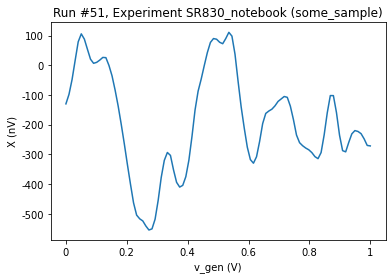

In [13]:
do0d(sr.ch1_datatrace, do_plot=True)

We are not restricted to sample on an equally spaced grid. We can set the sweep_array directly.  

In [17]:
grid_sample = np.concatenate((np.linspace(0, 0.5, 5),np.linspace(0.51, 1, 50)))
sr.sweep_setpoints.sweep_array = grid_sample
sr.sweep_setpoints.unit = gen.v_gen.unit
sr.sweep_setpoints.label = 'You also need to set label and unit'

In [18]:
sr.buffer_reset()
for v in grid_sample:
    gen.v_gen.set(v)
    sleep(0.04)
    sr.send_trigger()

Starting experimental run with id: 53. 


(results #53@C:\Users\Farzad\experiments.db
 ------------------------------------------
 lockin_sweep_setpoints - array
 lockin_ch1_datatrace - array,
 [<AxesSubplot:title={'center':'Run #53, Experiment SR830_notebook (some_sample)'}, xlabel='You also need to set label and unit (V)', ylabel='X (nV)'>],
 [None])

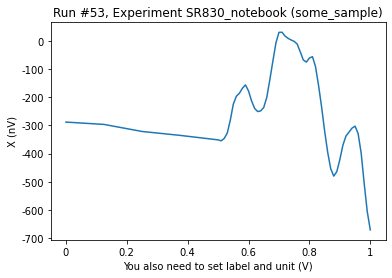

In [19]:
do0d(sr.ch1_datatrace, do_plot=True)